In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models


In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [17]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True, 
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

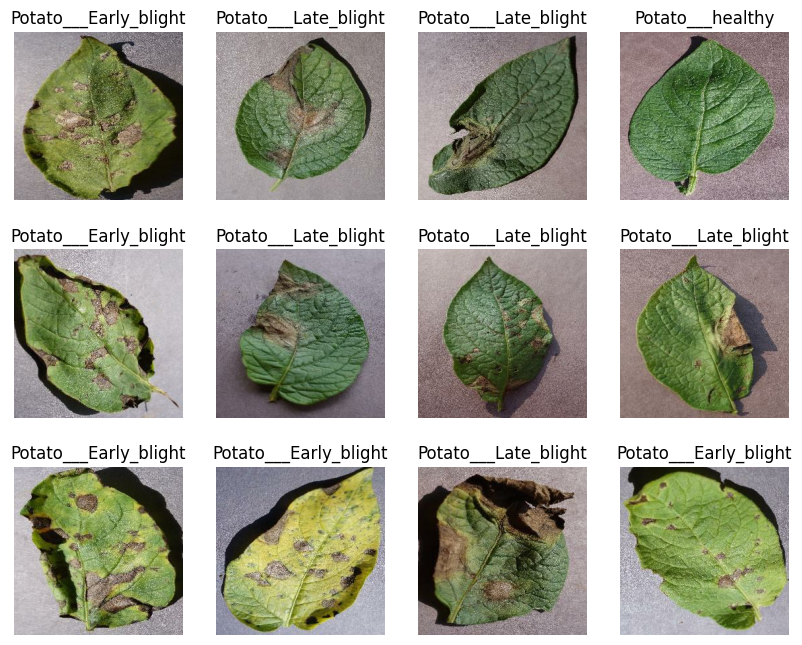

In [19]:
plt.figure(figsize=(10,8))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image_batch.numpy()[i].astype('uint8'))
        # expects 3D array
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        #print(image_batch.numpy())

In [22]:
def get_dataset_partitions_tf(dataset_tf, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=500):
    ds = len(dataset_tf)
    
    if shuffle:
        dataset_tf.shuffle(shuffle_size)
        
    train_size = int(train_split*ds)
    val_size  = int(val_split*ds)
    
    train_tf = dataset_tf.take(train_size)
    val_tf   = dataset_tf.skip(train_size).take(val_size)
    test_tf  = dataset_tf.skip(train_size).skip(val_size)
    
    return train_tf, val_tf, test_tf

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

54

#### cache data and prefectch images to be simultaneously used by CPU/GPU during READ/TRAIN to optimize performance

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resize and rescale

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation

In [33]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Creating NN architecture

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [41]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
             )

In [43]:
history = model.fit(train_ds,
         batch_size = BATCH_SIZE,
         epochs = 20,
         verbose=1,
         validation_data =val_ds)

Epoch 1/20
54/54 [==============================] - 115s 2s/step - loss: 0.1062 - accuracy: 0.9641 - val_loss: 0.2093 - val_accuracy: 0.9167
Epoch 2/20
54/54 [==============================] - 117s 2s/step - loss: 0.0851 - accuracy: 0.9682 - val_loss: 0.2539 - val_accuracy: 0.9062
Epoch 3/20
54/54 [==============================] - 116s 2s/step - loss: 0.1271 - accuracy: 0.9606 - val_loss: 0.1767 - val_accuracy: 0.9219
Epoch 4/20
54/54 [==============================] - 114s 2s/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.0949 - val_accuracy: 0.9740
Epoch 5/20
54/54 [==============================] - 116s 2s/step - loss: 0.0715 - accuracy: 0.9745 - val_loss: 0.2061 - val_accuracy: 0.9427
Epoch 6/20
54/54 [==============================] - 114s 2s/step - loss: 0.0773 - accuracy: 0.9699 - val_loss: 0.1407 - val_accuracy: 0.9583
Epoch 7/20
54/54 [==============================] - 120s 2s/step - loss: 0.0895 - accuracy: 0.9664 - val_loss: 0.1732 - val_accuracy: 0.9323
Epoch 8/20
54

In [45]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 585ms/step - loss: 0.3684 - accuracy: 0.8836


In [46]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
acc = history.history['accuracy']
loss = history.history['loss']
acc_val = history.history['val_accuracy']
val_loss = history.history['val_loss']

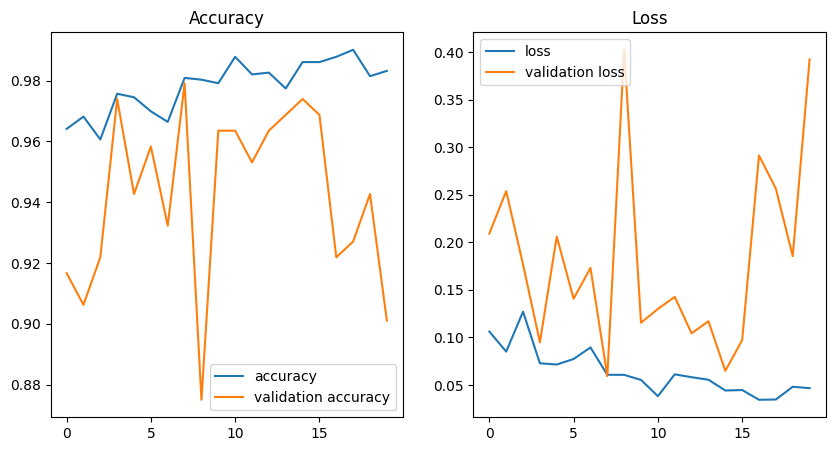

In [72]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label="accuracy")
plt.plot(range(20), acc_val, label="validation accuracy")
plt.title("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(range(20), loss, label="loss")
plt.plot(range(20), val_loss, label="validation loss")
plt.title("Loss")
plt.legend(loc="upper left")


actual label: Potato___Early_blight
1/1 [==============================] - 0s 378ms/step
[9.9999893e-01 1.1174138e-06 5.6011229e-13]
prediction: Potato___Early_blight


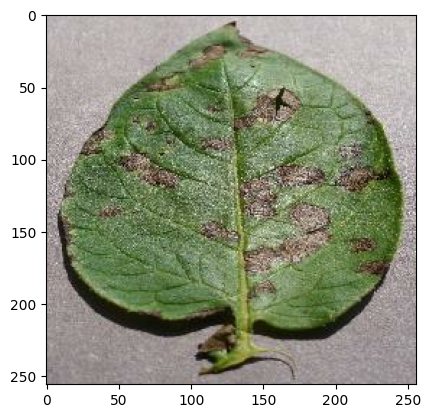

In [89]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('int')
    plt.imshow(first_image)
    actual_label = label_batch[0]
    print(f'actual label: {class_names[actual_label]}')
    predicted_label = model.predict(image_batch)
    print(predicted_label[0])
    print(f'prediction: {class_names[np.argmax(predicted_label[0])]}')
    


In [141]:
def prediction(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    pred_class = class_names[np.argmax(predictions[0])]
    conf =      round(np.max(predictions[0])*100, 2)
    return pred_class, conf

1/1 [==============================] - 0s 71ms/step


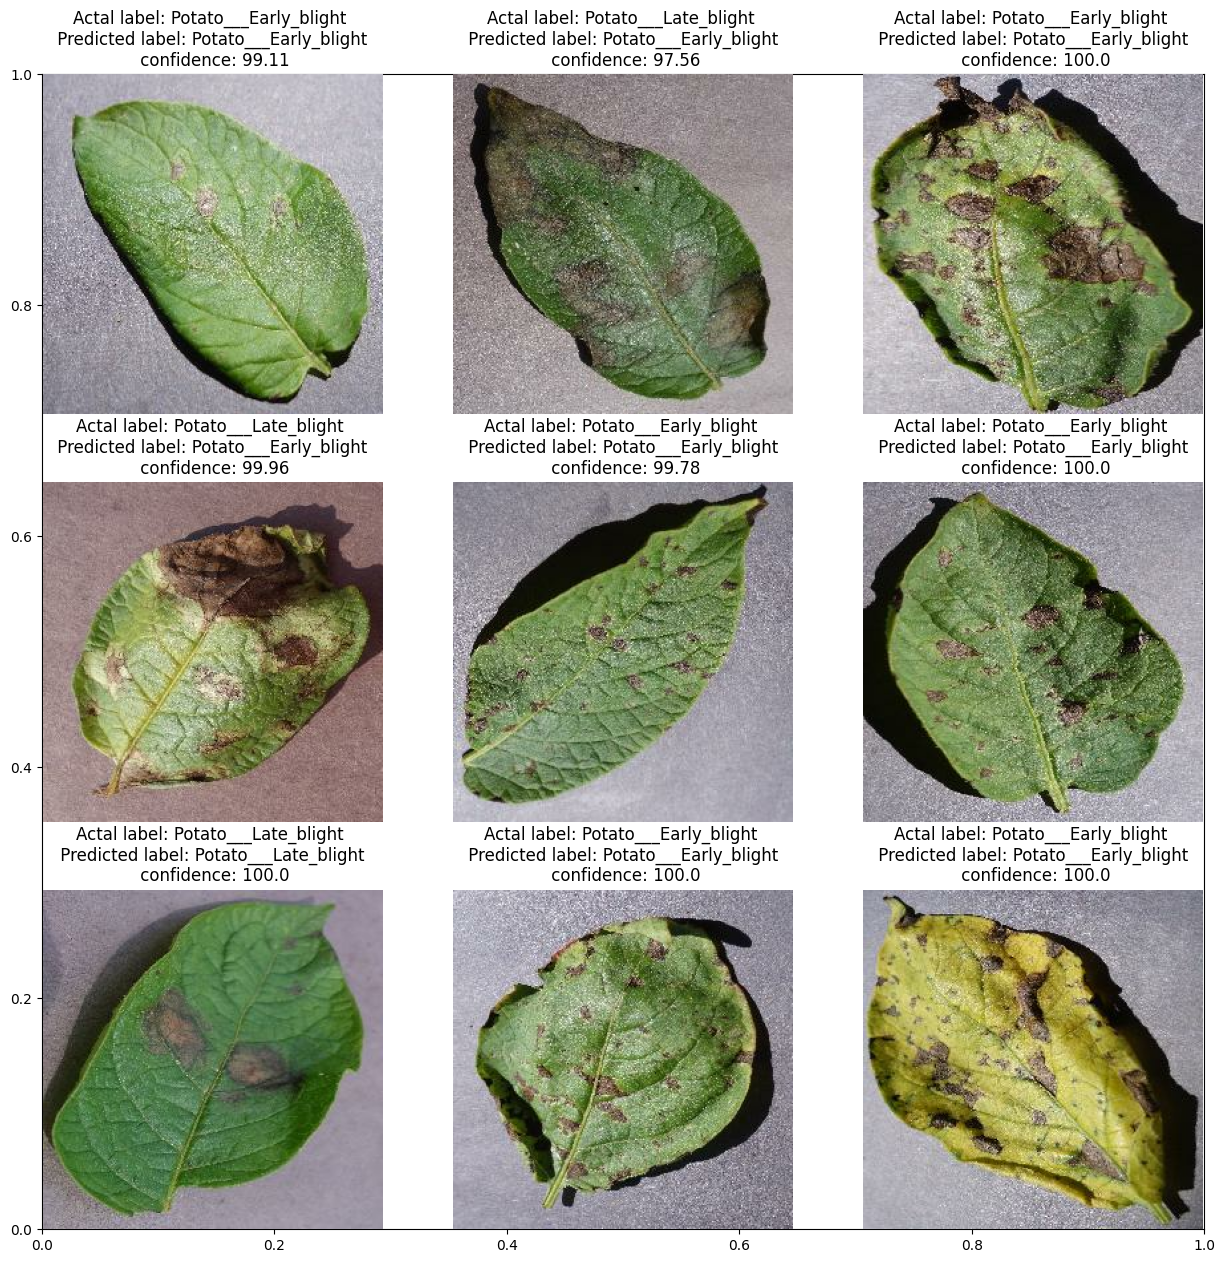

In [142]:
plt.subplots(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('int'))
        pred, conf = prediction(model, image_batch[i].numpy())
        plt.title(f"Actal label: {class_names[label_batch[i]]} \n Predicted label: {pred} \n confidence: {conf}")
        plt.axis('off')


In [143]:
version=1
model.save(f"../models/{version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
